In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [1]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, samples=None):
        self.feature = feature      # Feature to split on
        self.threshold = threshold  # Threshold for continuous features or categorical split value
        self.left = left           # Left child node
        self.right = right         # Right child node
        self.value = value         # Value for leaf nodes (prediction)
        self.samples = samples     # Number of samples in this node

In [3]:
class DecisionTreeID3:
    
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        
    def entropy(self, y):
        if len(y) == 0:
            return 0
        
        counts = np.bincount(y)
        probabilities = counts / len(y)
        entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        return entropy
    
    def information_gain(self, X_column, y, threshold=None):
        parent_entropy = self.entropy(y)
        
        if threshold is not None:
            # For continuous features
            left_indices = X_column <= threshold
            right_indices = X_column > threshold
        else:
            # For categorical features - split by unique values
            unique_values = np.unique(X_column)
            if len(unique_values) <= 1:
                return 0
            
            weighted_entropy = 0
            for value in unique_values:
                subset_indices = X_column == value
                subset_y = y[subset_indices]
                if len(subset_y) > 0:
                    weight = len(subset_y) / len(y)
                    weighted_entropy += weight * self.entropy(subset_y)
            
            return parent_entropy - weighted_entropy
        
        left_y = y[left_indices]
        right_y = y[right_indices]
        
        if len(left_y) == 0 or len(right_y) == 0:
            return 0
            
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        
        weighted_entropy = left_weight * self.entropy(left_y) + right_weight * self.entropy(right_y)
        return parent_entropy - weighted_entropy
    
    def best_split(self, X, y, continuous_features):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            if feature in continuous_features:
                unique_values = np.unique(X[:, feature])
                if len(unique_values) <= 1:
                    continue
                    
                thresholds = [(unique_values[i] + unique_values[i+1]) / 2 
                            for i in range(len(unique_values)-1)]
                
                for threshold in thresholds:
                    gain = self.information_gain(X[:, feature], y, threshold)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
            else:
                # For categorical features
                gain = self.information_gain(X[:, feature], y)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = None
        
        return best_feature, best_threshold, best_gain
    
    def build_tree(self, X, y, depth, continuous_features):
        # Check stopping criteria
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            len(np.unique(y)) == 1):
            # Create leaf node
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common, samples=len(y))
        
        # Find best split
        best_feature, best_threshold, best_gain = self.best_split(X, y, continuous_features)
        
        if best_feature is None or best_gain == 0:
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common, samples=len(y))
        
        # Create internal node
        node = Node(feature=best_feature, threshold=best_threshold, samples=len(y))
        
        # Split the data
        if best_threshold is not None:
            # Continuous feature split
            left_indices = X[:, best_feature] <= best_threshold
            right_indices = X[:, best_feature] > best_threshold
            
            node.left = self.build_tree(X[left_indices], y[left_indices], depth+1, continuous_features)
            node.right = self.build_tree(X[right_indices], y[right_indices], depth+1, continuous_features)
        else:
            # Categorical feature split - use binary splits
            most_common_value = Counter(X[:, best_feature]).most_common(1)[0][0]
            left_indices = X[:, best_feature] == most_common_value
            right_indices = X[:, best_feature] != most_common_value
            
            node.left = self.build_tree(X[left_indices], y[left_indices], depth+1, continuous_features)
            node.right = self.build_tree(X[right_indices], y[right_indices], depth+1, continuous_features)
            node.threshold = most_common_value  # Store the split value
        
        return node
    
    def fit(self, X, y, continuous_features=None):
        if continuous_features is None:
            continuous_features = set()
        
        # Convert labels to integers
        self.classes_ = np.unique(y)
        self.class_to_int = {cls: i for i, cls in enumerate(self.classes_)}
        self.int_to_class = {i: cls for cls, i in self.class_to_int.items()}
        
        y_int = np.array([self.class_to_int[cls] for cls in y])
        
        self.root = self.build_tree(X, y_int, 0, continuous_features)
    
    def predict_sample(self, x, node):
        if node.value is not None:
            return self.int_to_class[node.value]
        
        if node.threshold is not None:
            if node.feature in [i for i in range(len(x)) if isinstance(x[i], (int, float))]:
                # Continuous feature
                if x[node.feature] <= node.threshold:
                    return self.predict_sample(x, node.left)
                else:
                    return self.predict_sample(x, node.right)
            else:
                # Categorical feature stored as threshold
                if x[node.feature] == node.threshold:
                    return self.predict_sample(x, node.left)
                else:
                    return self.predict_sample(x, node.right)
    
    def predict(self, X):
        predictions = []
        for x in X:
            pred = self.predict_sample(x, self.root)
            predictions.append(pred)
        return np.array(predictions)


In [4]:
class DecisionTreeC45:
    """C4.5 Decision Tree Classifier Implementation"""
    
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        
    def entropy(self, y):
        """Calculate entropy of a dataset"""
        if len(y) == 0:
            return 0
        
        counts = np.bincount(y)
        probabilities = counts / len(y)
        entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        return entropy
    
    def split_info(self, X_column, threshold=None):
        """Calculate split information for gain ratio"""
        if threshold is not None:
            # For continuous features
            left_count = np.sum(X_column <= threshold)
            right_count = len(X_column) - left_count
            
            if left_count == 0 or right_count == 0:
                return 1e-10  # Avoid division by zero
                
            total = len(X_column)
            left_prob = left_count / total
            right_prob = right_count / total
            
            split_info = -(left_prob * np.log2(left_prob) + right_prob * np.log2(right_prob))
            return split_info
        else:
            # For categorical features
            unique_values = np.unique(X_column)
            if len(unique_values) <= 1:
                return 1e-10
                
            split_info = 0
            total = len(X_column)
            for value in unique_values:
                count = np.sum(X_column == value)
                if count > 0:
                    prob = count / total
                    split_info -= prob * np.log2(prob)
            
            return split_info if split_info > 0 else 1e-10
    
    def information_gain(self, X_column, y, threshold=None):
        """Calculate information gain for a feature"""
        parent_entropy = self.entropy(y)
        
        if threshold is not None:
            # For continuous features
            left_indices = X_column <= threshold
            right_indices = X_column > threshold
            
            left_y = y[left_indices]
            right_y = y[right_indices]
            
            if len(left_y) == 0 or len(right_y) == 0:
                return 0
                
            left_weight = len(left_y) / len(y)
            right_weight = len(right_y) / len(y)
            
            weighted_entropy = left_weight * self.entropy(left_y) + right_weight * self.entropy(right_y)
            return parent_entropy - weighted_entropy
        else:
            # For categorical features
            unique_values = np.unique(X_column)
            if len(unique_values) <= 1:
                return 0
            
            weighted_entropy = 0
            for value in unique_values:
                subset_indices = X_column == value
                subset_y = y[subset_indices]
                if len(subset_y) > 0:
                    weight = len(subset_y) / len(y)
                    weighted_entropy += weight * self.entropy(subset_y)
            
            return parent_entropy - weighted_entropy
    
    def gain_ratio(self, X_column, y, threshold=None):
        """Calculate gain ratio (C4.5 improvement over ID3)"""
        info_gain = self.information_gain(X_column, y, threshold)
        split_information = self.split_info(X_column, threshold)
        
        if split_information == 0:
            return 0
            
        return info_gain / split_information
    
    def best_split(self, X, y, continuous_features):
        """Find the best feature and threshold to split on using gain ratio"""
        best_gain_ratio = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            if feature in continuous_features:
                # For continuous features, try different thresholds
                unique_values = np.unique(X[:, feature])
                if len(unique_values) <= 1:
                    continue
                    
                thresholds = [(unique_values[i] + unique_values[i+1]) / 2 
                            for i in range(len(unique_values)-1)]
                
                for threshold in thresholds:
                    gr = self.gain_ratio(X[:, feature], y, threshold)
                    if gr > best_gain_ratio:
                        best_gain_ratio = gr
                        best_feature = feature
                        best_threshold = threshold
            else:
                # For categorical features
                gr = self.gain_ratio(X[:, feature], y)
                if gr > best_gain_ratio:
                    best_gain_ratio = gr
                    best_feature = feature
                    best_threshold = None
        
        return best_feature, best_threshold, best_gain_ratio
    
    def build_tree(self, X, y, depth, continuous_features):
        """Recursively build the decision tree using C4.5"""
        # Check stopping criteria
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or 
            len(np.unique(y)) == 1):
            # Create leaf node
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common, samples=len(y))
        
        # Find best split using gain ratio
        best_feature, best_threshold, best_gain_ratio = self.best_split(X, y, continuous_features)
        
        if best_feature is None or best_gain_ratio <= 0:
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common, samples=len(y))
        
        # Create internal node
        node = Node(feature=best_feature, threshold=best_threshold, samples=len(y))
        
        # Split the data
        if best_threshold is not None:
            # Continuous feature split
            left_indices = X[:, best_feature] <= best_threshold
            right_indices = X[:, best_feature] > best_threshold
            
            node.left = self.build_tree(X[left_indices], y[left_indices], depth+1, continuous_features)
            node.right = self.build_tree(X[right_indices], y[right_indices], depth+1, continuous_features)
        else:
            # For categorical features - use binary splits
            unique_values = np.unique(X[:, best_feature])
            if len(unique_values) == 2:
                # Binary split
                left_indices = X[:, best_feature] == unique_values[0]
                right_indices = X[:, best_feature] == unique_values[1]
                node.threshold = unique_values[0]  # Store split value
            else:
                # Multi-way split converted to binary (most common vs rest)
                most_common_value = Counter(X[:, best_feature]).most_common(1)[0][0]
                left_indices = X[:, best_feature] == most_common_value
                right_indices = X[:, best_feature] != most_common_value
                node.threshold = most_common_value
            
            node.left = self.build_tree(X[left_indices], y[left_indices], depth+1, continuous_features)
            node.right = self.build_tree(X[right_indices], y[right_indices], depth+1, continuous_features)
        
        return node
    
    def fit(self, X, y, continuous_features=None):
        """Train the C4.5 decision tree"""
        if continuous_features is None:
            continuous_features = set()
        
        # Convert labels to integers
        self.classes_ = np.unique(y)
        self.class_to_int = {cls: i for i, cls in enumerate(self.classes_)}
        self.int_to_class = {i: cls for cls, i in self.class_to_int.items()}
        
        y_int = np.array([self.class_to_int[cls] for cls in y])
        
        self.root = self.build_tree(X, y_int, 0, continuous_features)
    
    def predict_sample(self, x, node):
        """Predict a single sample"""
        if node.value is not None:
            return self.int_to_class[node.value]
        
        if node.threshold is not None:
            if node.feature in [i for i in range(len(x)) if isinstance(x[i], (int, float))]:
                # Continuous feature
                if x[node.feature] <= node.threshold:
                    return self.predict_sample(x, node.left)
                else:
                    return self.predict_sample(x, node.right)
            else:
                # Categorical feature
                if x[node.feature] == node.threshold:
                    return self.predict_sample(x, node.left)
                else:
                    return self.predict_sample(x, node.right)
    
    def predict(self, X):
        """Predict multiple samples"""
        predictions = []
        for x in X:
            pred = self.predict_sample(x, self.root)
            predictions.append(pred)
        return np.array(predictions)

print("C4.5 Decision Tree Classifier implemented!")


C4.5 Decision Tree Classifier implemented!


In [5]:
class DecisionTreeRegressor:
    """Decision Tree Regressor Implementation"""
    
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        
    def mse(self, y):
        """Calculate Mean Squared Error"""
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def variance_reduction(self, y, left_y, right_y):
        """Calculate variance reduction for regression"""
        if len(left_y) == 0 or len(right_y) == 0:
            return 0
        
        total_variance = self.mse(y)
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        
        weighted_variance = left_weight * self.mse(left_y) + right_weight * self.mse(right_y)
        
        return total_variance - weighted_variance
    
    def best_split(self, X, y):
        """Find the best feature and threshold to split on for regression"""
        best_var_reduction = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            unique_values = np.unique(X[:, feature])
            if len(unique_values) <= 1:
                continue
                
            # Try different thresholds
            thresholds = [(unique_values[i] + unique_values[i+1]) / 2 
                        for i in range(len(unique_values)-1)]
            
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold
                
                left_y = y[left_indices]
                right_y = y[right_indices]
                
                if len(left_y) < self.min_samples_leaf or len(right_y) < self.min_samples_leaf:
                    continue
                
                var_reduction = self.variance_reduction(y, left_y, right_y)
                
                if var_reduction > best_var_reduction:
                    best_var_reduction = var_reduction
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_var_reduction
    
    def build_tree(self, X, y, depth):
        """Recursively build the regression tree"""
        # Check stopping criteria
        if (depth >= self.max_depth or 
            len(y) < self.min_samples_split or
            len(y) < 2 * self.min_samples_leaf or
            self.mse(y) < 1e-7):  # Very low variance
            # Create leaf node with mean value
            return Node(value=np.mean(y), samples=len(y))
        
        # Find best split
        best_feature, best_threshold, best_var_reduction = self.best_split(X, y)
        
        if best_feature is None or best_var_reduction <= 0:
            return Node(value=np.mean(y), samples=len(y))
        
        # Create internal node
        node = Node(feature=best_feature, threshold=best_threshold, samples=len(y))
        
        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        node.left = self.build_tree(X[left_indices], y[left_indices], depth+1)
        node.right = self.build_tree(X[right_indices], y[right_indices], depth+1)
        
        return node
    
    def fit(self, X, y):
        """Train the regression tree"""
        self.root = self.build_tree(X, y, 0)
    
    def predict_sample(self, x, node):
        """Predict a single sample"""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self.predict_sample(x, node.left)
        else:
            return self.predict_sample(x, node.right)
    
    def predict(self, X):
        """Predict multiple samples"""
        predictions = []
        for x in X:
            pred = self.predict_sample(x, self.root)
            predictions.append(pred)
        return np.array(predictions)

print("Decision Tree Regressor implemented!")


Decision Tree Regressor implemented!


In [6]:
def preprocess_data(df, target_column, task_type='classification'):
    """Preprocess data for decision tree algorithms"""
    
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column].values
    
    # Handle missing values if any
    X = X.fillna(X.mode().iloc[0])
    
    # Identify continuous and categorical features
    continuous_features = set()
    categorical_features = set()
    
    processed_X = X.copy()
    
    for i, col in enumerate(X.columns):
        if X[col].dtype in ['int64', 'float64']:
            continuous_features.add(i)
            # For classification, convert continuous to boolean based on median threshold
            if task_type == 'classification':
                threshold = X[col].median()
                processed_X[col] = (X[col] > threshold).astype(int)
                categorical_features.add(i)
                continuous_features.discard(i)
        else:
            categorical_features.add(i)
            # Encode categorical variables
            unique_vals = X[col].unique()
            val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
            processed_X[col] = X[col].map(val_to_int)
    
    return processed_X.values, y, continuous_features, categorical_features

print("Data preprocessing function defined!")


Data preprocessing function defined!


In [7]:
def evaluate_classification(y_true, y_pred):
    """Evaluate classification performance"""
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision, recall, f1 for each class
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for cls in unique_classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    return {
        'accuracy': accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

def evaluate_regression(y_true, y_pred):
    """Evaluate regression performance"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    
    return {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mae': mae
    }

print("Evaluation functions defined!")


Evaluation functions defined!


In [8]:
def cross_validate_classification(X, y, continuous_features, algorithm='ID3', k_folds=5):
    """Perform k-fold cross validation for classification"""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    results = []
    fold = 1
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train model
        if algorithm == 'ID3':
            model = DecisionTreeID3(max_depth=10, min_samples_split=2)
        else:  # C4.5
            model = DecisionTreeC45(max_depth=10, min_samples_split=2)
        
        model.fit(X_train, y_train, continuous_features)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate
        metrics = evaluate_classification(y_test, y_pred)
        metrics['fold'] = fold
        results.append(metrics)
        fold += 1
    
    return results

def cross_validate_regression(X, y, k_folds=5):
    """Perform k-fold cross validation for regression"""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    results = []
    fold = 1
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train model
        model = DecisionTreeRegressor(max_depth=10, min_samples_split=2)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate
        metrics = evaluate_regression(y_test, y_pred)
        metrics['fold'] = fold
        results.append(metrics)
        fold += 1
    
    return results

def print_results(results, task_type='classification'):
    """Print cross-validation results"""
    if task_type == 'classification':
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        print(f"{'Fold':<6}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}")
        print("-" * 54)
        
        for result in results:
            print(f"{result['fold']:<6}{result['accuracy']:<12.4f}{result['precision']:<12.4f}{result['recall']:<12.4f}{result['f1']:<12.4f}")
        
        # Calculate averages
        avg_metrics = {metric: np.mean([r[metric] for r in results]) for metric in metrics}
        std_metrics = {metric: np.std([r[metric] for r in results]) for metric in metrics}
        
        print("-" * 54)
        print(f"{'Mean':<6}{avg_metrics['accuracy']:<12.4f}{avg_metrics['precision']:<12.4f}{avg_metrics['recall']:<12.4f}{avg_metrics['f1']:<12.4f}")
        print(f"{'Std':<6}{std_metrics['accuracy']:<12.4f}{std_metrics['precision']:<12.4f}{std_metrics['recall']:<12.4f}{std_metrics['f1']:<12.4f}")
        
    else:  # regression
        metrics = ['mse', 'rmse', 'r2', 'mae']
        print(f"{'Fold':<6}{'MSE':<12}{'RMSE':<12}{'R²':<12}{'MAE':<12}")
        print("-" * 54)
        
        for result in results:
            print(f"{result['fold']:<6}{result['mse']:<12.4f}{result['rmse']:<12.4f}{result['r2']:<12.4f}{result['mae']:<12.4f}")
        
        # Calculate averages
        avg_metrics = {metric: np.mean([r[metric] for r in results]) for metric in metrics}
        std_metrics = {metric: np.std([r[metric] for r in results]) for metric in metrics}
        
        print("-" * 54)
        print(f"{'Mean':<6}{avg_metrics['mse']:<12.4f}{avg_metrics['rmse']:<12.4f}{avg_metrics['r2']:<12.4f}{avg_metrics['mae']:<12.4f}")
        print(f"{'Std':<6}{std_metrics['mse']:<12.4f}{std_metrics['rmse']:<12.4f}{std_metrics['r2']:<12.4f}{std_metrics['mae']:<12.4f}")

print("Cross-validation functions defined!")


Cross-validation functions defined!


In [10]:
# Load datasets
try:
    cricket_df = pd.read_csv('playCricket - playCricket.csv')
    drug_df = pd.read_csv('drug_200 - drug_200.csv')  
    petrol_df = pd.read_csv('petrol_consumption - petrol_consumption.csv')
    
    print("All datasets loaded successfully!")
    print(f"PlayCricket Dataset: {cricket_df.shape}")
    print(f"Drug Dataset: {drug_df.shape}")
    print(f"Petrol Consumption Dataset: {petrol_df.shape}")
    
except FileNotFoundError as e:
    print(f"Error loading datasets: {e}")
    print("Make sure all CSV files are in the same directory as this notebook")


All datasets loaded successfully!
PlayCricket Dataset: (14, 6)
Drug Dataset: (200, 6)
Petrol Consumption Dataset: (48, 5)


In [11]:
print("=" * 80)
print("TASK 1: PlayCricket Dataset - Decision Tree Classification")
print("-" * 60)

# Preprocess data
X_cricket, y_cricket, cont_features_cricket, cat_features_cricket = preprocess_data(
    cricket_df, 'PlayCricket', 'classification'
)

print(f"Dataset shape: {X_cricket.shape}")
print(f"Classes: {np.unique(y_cricket)}")
print(f"Continuous features converted to binary: {cont_features_cricket}")
print(f"Categorical features: {cat_features_cricket}")
print()

# ID3 Algorithm
print("ID3 Algorithm Results:")
id3_results_cricket = cross_validate_classification(
    X_cricket, y_cricket, cont_features_cricket, algorithm='ID3', k_folds=5
)
print_results(id3_results_cricket, 'classification')
print()

# C4.5 Algorithm
print("C4.5 Algorithm Results:")
c45_results_cricket = cross_validate_classification(
    X_cricket, y_cricket, cont_features_cricket, algorithm='C4.5', k_folds=5
)
print_results(c45_results_cricket, 'classification')
print("=" * 80)


TASK 1: PlayCricket Dataset - Decision Tree Classification
------------------------------------------------------------
Dataset shape: (14, 5)
Classes: ['No' 'Yes']
Continuous features converted to binary: set()
Categorical features: {0, 1, 2, 3, 4}

ID3 Algorithm Results:
Fold  Accuracy    Precision   Recall      F1-Score    
------------------------------------------------------
1     0.3333      0.1667      0.5000      0.2500      
2     0.3333      0.1667      0.5000      0.2500      
3     0.3333      0.1667      0.5000      0.2500      
4     0.3333      0.1667      0.5000      0.2500      
5     1.0000      1.0000      1.0000      1.0000      
------------------------------------------------------
Mean  0.4667      0.3333      0.6000      0.4000      
Std   0.2667      0.3333      0.2000      0.3000      

C4.5 Algorithm Results:
Fold  Accuracy    Precision   Recall      F1-Score    
------------------------------------------------------
1     0.3333      0.1667      0.5000     

In [12]:
print("TASK 2: Drug Dataset - Decision Tree Classification")
print("-" * 60)

# Preprocess data - Age and Na_to_K are continuous, need to convert to binary for classification
X_drug, y_drug, cont_features_drug, cat_features_drug = preprocess_data(
    drug_df, 'Drug', 'classification'
)

print(f"Dataset shape: {X_drug.shape}")
print(f"Classes: {np.unique(y_drug)}")
print(f"Original continuous features (Age, Na_to_K) converted to binary")
print(f"Continuous features after conversion: {cont_features_drug}")
print(f"Categorical features: {cat_features_drug}")
print()

# ID3 Algorithm
print("ID3 Algorithm Results:")
id3_results_drug = cross_validate_classification(
    X_drug, y_drug, cont_features_drug, algorithm='ID3', k_folds=5
)
print_results(id3_results_drug, 'classification')
print()

# C4.5 Algorithm
print("C4.5 Algorithm Results:")
c45_results_drug = cross_validate_classification(
    X_drug, y_drug, cont_features_drug, algorithm='C4.5', k_folds=5
)
print_results(c45_results_drug, 'classification')
print("=" * 80)


TASK 2: Drug Dataset - Decision Tree Classification
------------------------------------------------------------
Dataset shape: (200, 5)
Classes: ['drugA' 'drugB' 'drugC' 'drugX' 'drugY']
Original continuous features (Age, Na_to_K) converted to binary
Continuous features after conversion: set()
Categorical features: {0, 1, 2, 3, 4}

ID3 Algorithm Results:
Fold  Accuracy    Precision   Recall      F1-Score    
------------------------------------------------------
1     0.9000      0.9049      0.9000      0.8937      
2     0.9000      0.8966      0.8611      0.8743      
3     0.8750      0.9018      0.8752      0.8828      
4     0.9000      0.9010      0.8778      0.8616      
5     0.9500      0.9792      0.9545      0.9641      
------------------------------------------------------
Mean  0.9050      0.9167      0.8937      0.8953      
Std   0.0245      0.0314      0.0329      0.0360      

C4.5 Algorithm Results:
Fold  Accuracy    Precision   Recall      F1-Score    
------------

In [13]:
print("TASK 3: Petrol Consumption Dataset - Decision Tree Regression")
print("-" * 60)

# Preprocess data for regression (keep continuous features as they are)
X_petrol, y_petrol, cont_features_petrol, cat_features_petrol = preprocess_data(
    petrol_df, 'Petrol_Consumption', 'regression'
)

print(f"Dataset shape: {X_petrol.shape}")
print(f"Target range: {y_petrol.min():.2f} - {y_petrol.max():.2f}")
print(f"All features are continuous for regression task")
print(f"Continuous features: {cont_features_petrol}")
print()

# Decision Tree Regression
print("Decision Tree Regression Results:")
regression_results = cross_validate_regression(X_petrol, y_petrol, k_folds=5)
print_results(regression_results, 'regression')
print("=" * 80)


TASK 3: Petrol Consumption Dataset - Decision Tree Regression
------------------------------------------------------------
Dataset shape: (48, 4)
Target range: 344.00 - 968.00
All features are continuous for regression task
Continuous features: {0, 1, 2, 3}

Decision Tree Regression Results:
Fold  MSE         RMSE        R²          MAE         
------------------------------------------------------
1     17026.8000  130.4868    -1.5379     88.6000     
2     17356.3000  131.7433    0.3931      104.7000    
3     7292.5000   85.3961     -1.8169     67.7000     
4     5117.2222   71.5348     0.2200      64.5556     
5     13510.3333  116.2340    -0.0155     68.1111     
------------------------------------------------------
Mean  12060.6311  107.0790    -0.5515     78.7333     
Std   5015.0689   24.3869     0.9326      15.5383     


In [14]:
# Additional imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Visualization libraries imported successfully!")


Visualization libraries imported successfully!


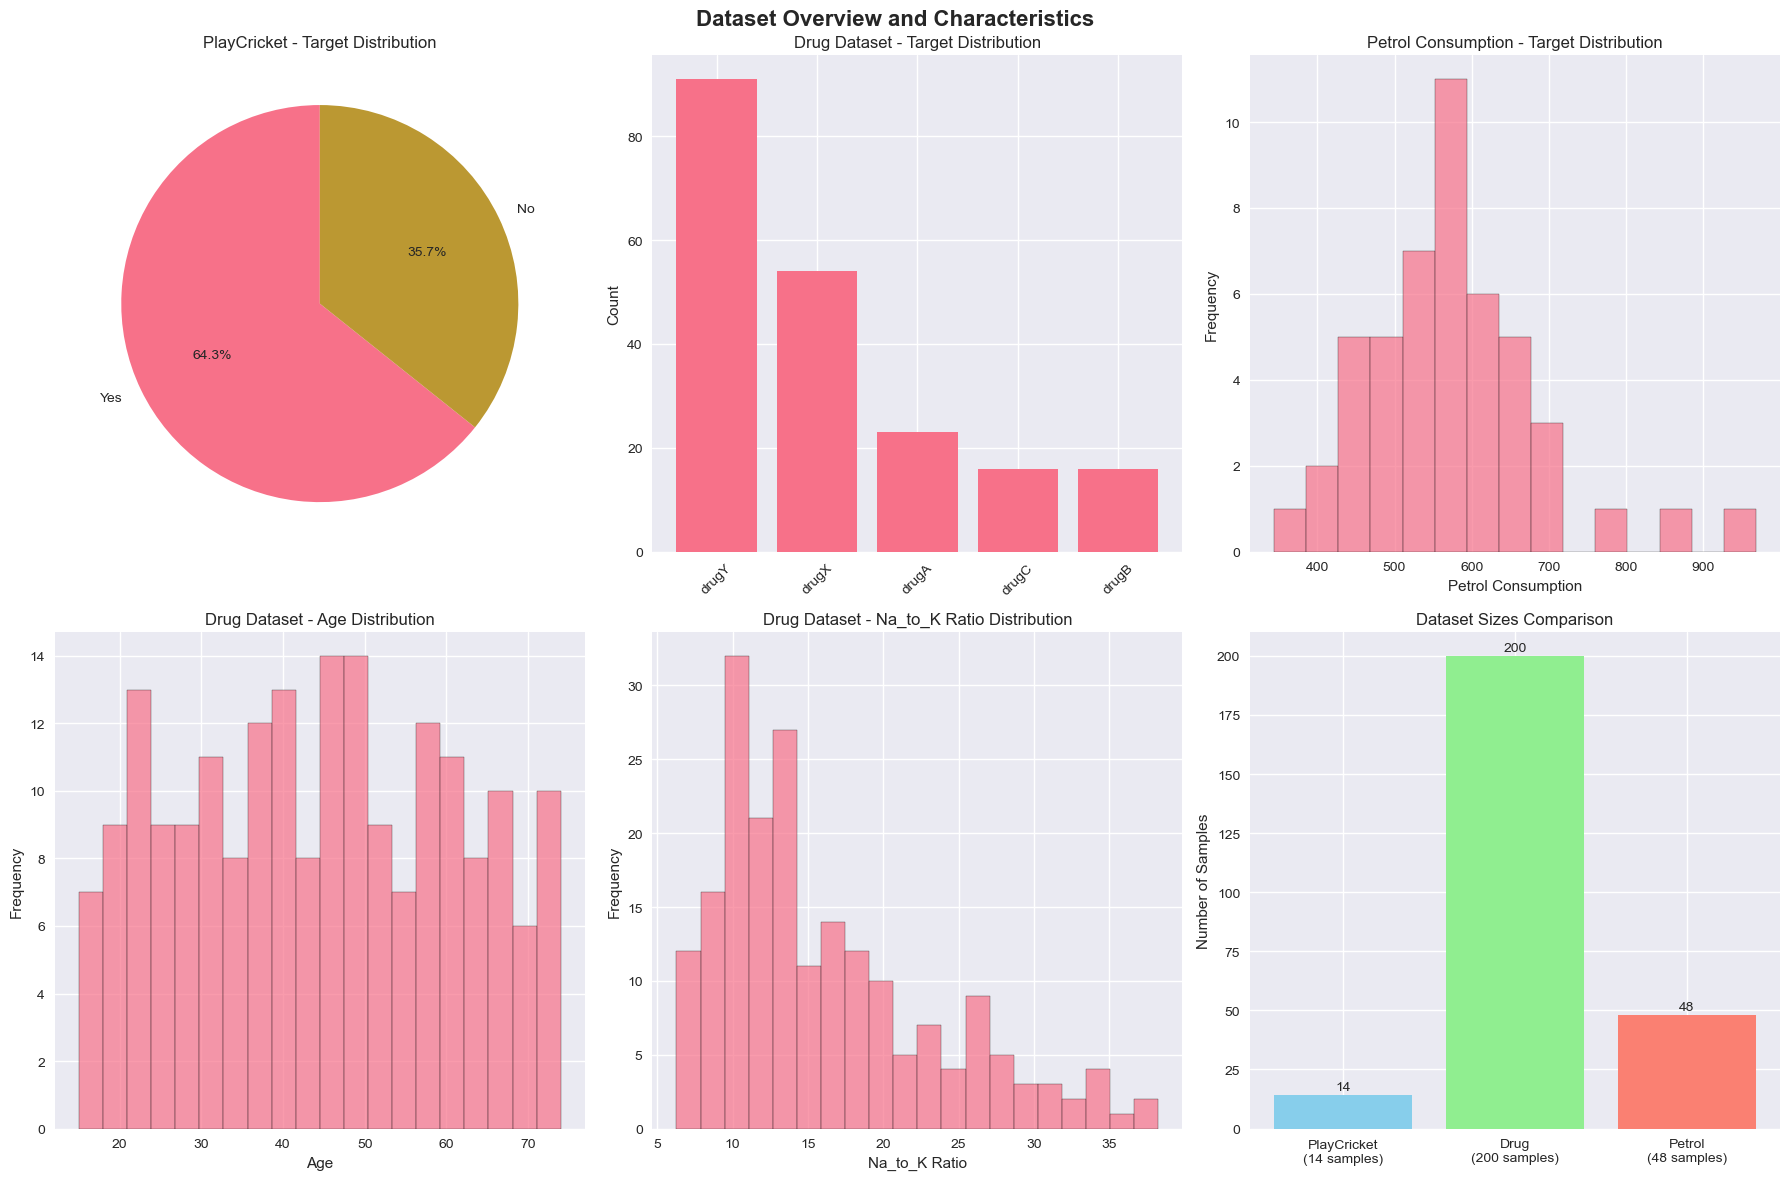

In [15]:
def plot_dataset_overview():
    """Create comprehensive dataset overview plots"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Dataset Overview and Characteristics', fontsize=16, fontweight='bold')
    
    # PlayCricket Dataset Analysis
    axes[0, 0].pie(cricket_df['PlayCricket'].value_counts().values, 
                   labels=cricket_df['PlayCricket'].value_counts().index,
                   autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('PlayCricket - Target Distribution')
    
    # Drug Dataset Analysis
    drug_counts = drug_df['Drug'].value_counts()
    axes[0, 1].bar(range(len(drug_counts)), drug_counts.values)
    axes[0, 1].set_xticks(range(len(drug_counts)))
    axes[0, 1].set_xticklabels(drug_counts.index, rotation=45)
    axes[0, 1].set_title('Drug Dataset - Target Distribution')
    axes[0, 1].set_ylabel('Count')
    
    # Petrol Dataset - Target Distribution
    axes[0, 2].hist(petrol_df['Petrol_Consumption'], bins=15, alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('Petrol Consumption - Target Distribution')
    axes[0, 2].set_xlabel('Petrol Consumption')
    axes[0, 2].set_ylabel('Frequency')
    
    # Feature analysis for Drug dataset
    axes[1, 0].hist(drug_df['Age'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Drug Dataset - Age Distribution')
    axes[1, 0].set_xlabel('Age')
    axes[1, 0].set_ylabel('Frequency')
    
    # Feature analysis for Drug dataset - Na_to_K
    axes[1, 1].hist(drug_df['Na_to_K'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Drug Dataset - Na_to_K Ratio Distribution')
    axes[1, 1].set_xlabel('Na_to_K Ratio')
    axes[1, 1].set_ylabel('Frequency')
    
    # Dataset size comparison
    dataset_sizes = [cricket_df.shape[0], drug_df.shape[0], petrol_df.shape[0]]
    dataset_names = ['PlayCricket\n(14 samples)', 'Drug\n(200 samples)', 'Petrol\n(48 samples)']
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    bars = axes[1, 2].bar(dataset_names, dataset_sizes, color=colors)
    axes[1, 2].set_title('Dataset Sizes Comparison')
    axes[1, 2].set_ylabel('Number of Samples')
    
    # Add value labels on bars
    for bar, size in zip(bars, dataset_sizes):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{size}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_dataset_overview()


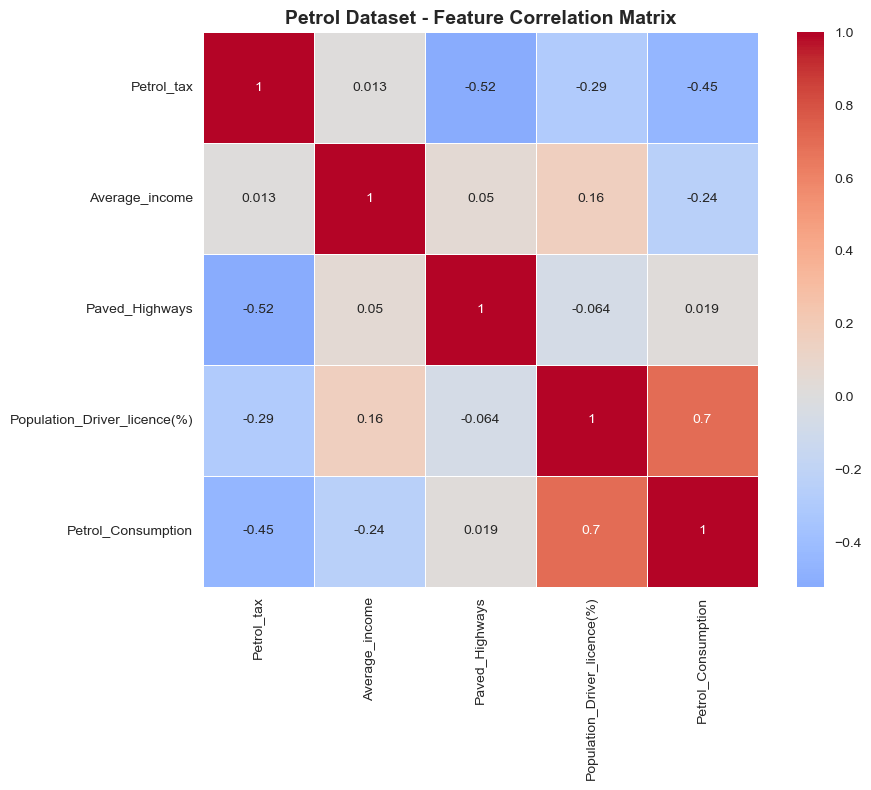

In [16]:
def create_interactive_feature_analysis():
    """Create interactive plots for feature analysis"""
    
    # Drug dataset interactive analysis
    fig_drug = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Age vs Drug Type', 'Na_to_K vs Drug Type', 
                       'BP Distribution', 'Sex Distribution'),
        specs=[[{"type": "scatter"}, {"type": "scatter"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Age vs Drug scatter plot
    for drug in drug_df['Drug'].unique():
        drug_data = drug_df[drug_df['Drug'] == drug]
        fig_drug.add_trace(
            go.Scatter(x=drug_data['Age'], y=drug_data['Na_to_K'],
                      mode='markers', name=f'Drug {drug}',
                      text=drug_data['Drug']),
            row=1, col=1
        )
    
    # Na_to_K vs Drug scatter plot
    fig_drug.add_trace(
        go.Box(y=drug_df['Na_to_K'], x=drug_df['Drug'], name='Na_to_K by Drug'),
        row=1, col=2
    )
    
    # BP distribution
    bp_counts = drug_df['BP'].value_counts()
    fig_drug.add_trace(
        go.Bar(x=bp_counts.index, y=bp_counts.values, name='BP Distribution'),
        row=2, col=1
    )
    
    # Sex distribution
    sex_counts = drug_df['Sex'].value_counts()
    fig_drug.add_trace(
        go.Bar(x=sex_counts.index, y=sex_counts.values, name='Sex Distribution'),
        row=2, col=2
    )
    
    fig_drug.update_layout(height=800, title_text="Drug Dataset - Interactive Feature Analysis")
    fig_drug.show()
    
    # Petrol dataset correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = petrol_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Petrol Dataset - Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

create_interactive_feature_analysis()


In [30]:
def plot_performance_comparison(id3_cricket, c45_cricket, id3_drug, c45_drug, regression_results):
    """Create comprehensive performance comparison plots"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Algorithm Performance Comparison Across All Tasks', fontsize=16, fontweight='bold')
    
    # PlayCricket - Accuracy Comparison
    id3_acc = [r['accuracy'] for r in id3_cricket]
    c45_acc = [r['accuracy'] for r in c45_cricket]
    
    x_pos = range(1, 6)
    width = 0.35
    
    axes[0, 0].bar([x - width/2 for x in x_pos], id3_acc, width, label='ID3', alpha=0.8)
    axes[0, 0].bar([x + width/2 for x in x_pos], c45_acc, width, label='C4.5', alpha=0.8)
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('PlayCricket Dataset - Accuracy by Fold')
    axes[0, 0].legend()
    axes[0, 0].set_xticks(x_pos)
    
    # Drug Dataset - Accuracy Comparison
    id3_acc_drug = [r['accuracy'] for r in id3_drug]
    c45_acc_drug = [r['accuracy'] for r in c45_drug]
    
    axes[0, 1].bar([x - width/2 for x in x_pos], id3_acc_drug, width, label='ID3', alpha=0.8)
    axes[0, 1].bar([x + width/2 for x in x_pos], c45_acc_drug, width, label='C4.5', alpha=0.8)
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Drug Dataset - Accuracy by Fold')
    axes[0, 1].legend()
    axes[0, 1].set_xticks(x_pos)
    
    # Regression - R² Score
    r2_scores = [r['r2'] for r in regression_results]
    axes[0, 2].plot(x_pos, r2_scores, 'o-', linewidth=2, markersize=8)
    axes[0, 2].set_xlabel('Fold')
    axes[0, 2].set_ylabel('R² Score')
    axes[0, 2].set_title('Petrol Dataset - R² Score by Fold')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_xticks(x_pos)
    
    # Average Performance Comparison
    algorithms = ['ID3\n(PlayCricket)', 'C4.5\n(PlayCricket)', 'ID3\n(Drug)', 'C4.5\n(Drug)']
    avg_accuracies = [
        np.mean(id3_acc),
        np.mean(c45_acc),
        np.mean(id3_acc_drug),
        np.mean(c45_acc_drug)
    ]
    
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    bars = axes[1, 0].bar(algorithms, avg_accuracies, color=colors)
    axes[1, 0].set_ylabel('Average Accuracy')
    axes[1, 0].set_title('Average Accuracy Comparison')
    axes[1, 0].set_ylim(0, 1)
    
    # Add value labels
    for bar, acc in zip(bars, avg_accuracies):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom')
    
    # F1-Score Comparison
    id3_f1 = [r['f1'] for r in id3_cricket]
    c45_f1 = [r['f1'] for r in c45_cricket]
    id3_f1_drug = [r['f1'] for r in id3_drug]
    c45_f1_drug = [r['f1'] for r in c45_drug]
    
    f1_data = [id3_f1, c45_f1, id3_f1_drug, c45_f1_drug]
    labels = ['ID3 (Cricket)', 'C4.5 (Cricket)', 'ID3 (Drug)', 'C4.5 (Drug)']
    
    bp = axes[1, 1].boxplot(f1_data, labels=labels, patch_artist=True)
    colors_box = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
    
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_title('F1-Score Distribution Comparison')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Regression Metrics - FIXED SECTION
    reg_metrics = ['MSE', 'RMSE', 'R²', 'MAE']
    reg_values = [
        np.mean([r['mse'] for r in regression_results]),
        np.mean([r['rmse'] for r in regression_results]),
        np.mean([r['r2'] for r in regression_results]),
        np.mean([r['mae'] for r in regression_results])
    ]
    
    # Normalize values for better visualization
    reg_values_norm = [
        reg_values[0] / 10000,  # MSE in 10k units
        reg_values[1] / 100,    # RMSE in 100 units
        reg_values[2],          # R² as is
        reg_values[3] / 100     # MAE in 100 units
    ]
    
    bars = axes[1, 2].bar(reg_metrics, reg_values_norm, color='orange', alpha=0.7)
    axes[1, 2].set_ylabel('Normalized Metric Value')
    axes[1, 2].set_title('Regression Metrics (Normalized)')
    
    # Add actual value labels - FIXED: Use reg_values instead of undefined 'val'
    labels_actual = [f'{reg_values[0]:.1f}', f'{reg_values[1]:.1f}', f'{reg_values[2]:.3f}', f'{reg_values[3]:.1f}']
    for bar, label in zip(bars, labels_actual):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        label, ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

print("CORRECTED: Performance comparison function updated!")


CORRECTED: Performance comparison function updated!


In [31]:
def create_interactive_cv_results(id3_cricket, c45_cricket, id3_drug, c45_drug, regression_results):
    """Create interactive cross-validation results visualization"""
    
    # Check if we have plotly installed
    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        # Classification Results
        fig_classification = go.Figure()
        
        # PlayCricket results
        folds = list(range(1, 6))
        
        fig_classification.add_trace(go.Scatter(
            x=folds,
            y=[r['accuracy'] for r in id3_cricket],
            mode='lines+markers',
            name='ID3 - PlayCricket',
            line=dict(width=3),
            marker=dict(size=8)
        ))
        
        fig_classification.add_trace(go.Scatter(
            x=folds,
            y=[r['accuracy'] for r in c45_cricket],
            mode='lines+markers',
            name='C4.5 - PlayCricket',
            line=dict(width=3),
            marker=dict(size=8)
        ))
        
        fig_classification.add_trace(go.Scatter(
            x=folds,
            y=[r['accuracy'] for r in id3_drug],
            mode='lines+markers',
            name='ID3 - Drug',
            line=dict(width=3),
            marker=dict(size=8)
        ))
        
        fig_classification.add_trace(go.Scatter(
            x=folds,
            y=[r['accuracy'] for r in c45_drug],
            mode='lines+markers',
            name='C4.5 - Drug',
            line=dict(width=3),
            marker=dict(size=8)
        ))
        
        fig_classification.update_layout(
            title='Cross-Validation Accuracy Across Folds',
            xaxis_title='Fold Number',
            yaxis_title='Accuracy',
            hovermode='x unified',
            height=500
        )
        
        fig_classification.show()
        
        # Regression Results
        fig_regression = make_subplots(
            rows=2, cols=2,
            subplot_titles=('MSE by Fold', 'RMSE by Fold', 'R² by Fold', 'MAE by Fold')
        )
        
        metrics = ['mse', 'rmse', 'r2', 'mae']
        titles = ['MSE', 'RMSE', 'R²', 'MAE']
        positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
        
        for metric, title, (row, col) in zip(metrics, titles, positions):
            values = [r[metric] for r in regression_results]
            
            fig_regression.add_trace(
                go.Scatter(x=folds, y=values, mode='lines+markers',
                          name=title, line=dict(width=3), marker=dict(size=8)),
                row=row, col=col
            )
        
        fig_regression.update_layout(height=600, title_text="Regression Metrics Across Folds")
        fig_regression.show()
        
    except ImportError:
        print("Plotly not available. Using matplotlib instead...")
        
        # Fallback to matplotlib
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Cross-Validation Results', fontsize=16)
        
        folds = list(range(1, 6))
        
        # Classification accuracy
        axes[0, 0].plot(folds, [r['accuracy'] for r in id3_cricket], 'o-', label='ID3-Cricket')
        axes[0, 0].plot(folds, [r['accuracy'] for r in c45_cricket], 's-', label='C4.5-Cricket')
        axes[0, 0].plot(folds, [r['accuracy'] for r in id3_drug], '^-', label='ID3-Drug')
        axes[0, 0].plot(folds, [r['accuracy'] for r in c45_drug], 'd-', label='C4.5-Drug')
        axes[0, 0].set_title('Accuracy Across Folds')
        axes[0, 0].set_xlabel('Fold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Regression metrics
        regression_metrics = ['mse', 'rmse', 'r2']
        titles = ['MSE', 'RMSE', 'R²']
        positions = [(0, 1), (1, 0), (1, 1)]
        
        for metric, title, (row, col) in zip(regression_metrics, titles, positions):
            values = [r[metric] for r in regression_results]
            axes[row, col].plot(folds, values, 'o-', linewidth=2, markersize=6)
            axes[row, col].set_title(f'{title} Across Folds')
            axes[row, col].set_xlabel('Fold')
            axes[row, col].set_ylabel(title)
            axes[row, col].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("CORRECTED: Interactive CV results function updated!")


CORRECTED: Interactive CV results function updated!


In [32]:
def run_complete_analysis():
    """Run complete analysis with all visualizations and error handling"""
    
    print("🚀 Starting Complete ML Assignment Analysis with Visualizations...")
    print("=" * 80)
    
    try:
        # Task 1: PlayCricket Dataset
        print("\n📊 TASK 1: PlayCricket Dataset Analysis")
        print("-" * 60)
        
        X_cricket, y_cricket, cont_features_cricket, cat_features_cricket = preprocess_data(
            cricket_df, 'PlayCricket', 'classification'
        )
        
        print("Running ID3 on PlayCricket dataset...")
        id3_results_cricket = cross_validate_classification(
            X_cricket, y_cricket, cont_features_cricket, algorithm='ID3', k_folds=5
        )
        
        print("Running C4.5 on PlayCricket dataset...")
        c45_results_cricket = cross_validate_classification(
            X_cricket, y_cricket, cont_features_cricket, algorithm='C4.5', k_folds=5
        )
        
        print("✅ PlayCricket analysis completed!")
        
        # Print results
        print("\nID3 Results:")
        print_results(id3_results_cricket, 'classification')
        print("\nC4.5 Results:")
        print_results(c45_results_cricket, 'classification')
        
        # Task 2: Drug Dataset
        print("\n💊 TASK 2: Drug Dataset Analysis")
        print("-" * 60)
        
        X_drug, y_drug, cont_features_drug, cat_features_drug = preprocess_data(
            drug_df, 'Drug', 'classification'
        )
        
        print("Running ID3 on Drug dataset...")
        id3_results_drug = cross_validate_classification(
            X_drug, y_drug, cont_features_drug, algorithm='ID3', k_folds=5
        )
        
        print("Running C4.5 on Drug dataset...")
        c45_results_drug = cross_validate_classification(
            X_drug, y_drug, cont_features_drug, algorithm='C4.5', k_folds=5
        )
        
        print("✅ Drug dataset analysis completed!")
        
        # Print results
        print("\nID3 Results:")
        print_results(id3_results_drug, 'classification')
        print("\nC4.5 Results:")
        print_results(c45_results_drug, 'classification')
        
        # Task 3: Petrol Dataset
        print("\n⛽ TASK 3: Petrol Consumption Analysis")
        print("-" * 60)
        
        X_petrol, y_petrol, cont_features_petrol, cat_features_petrol = preprocess_data(
            petrol_df, 'Petrol_Consumption', 'regression'
        )
        
        print("Running Decision Tree Regression on Petrol dataset...")
        regression_results = cross_validate_regression(X_petrol, y_petrol, k_folds=5)
        
        print("✅ Petrol dataset analysis completed!")
        
        # Print results
        print("\nRegression Results:")
        print_results(regression_results, 'regression')
        
        # Store results for visualization
        results_dict = {
            'id3_cricket': id3_results_cricket,
            'c45_cricket': c45_results_cricket,
            'id3_drug': id3_results_drug,
            'c45_drug': c45_results_drug,
            'regression': regression_results
        }
        
        # Generate all visualizations
        print("\n📈 Generating Comprehensive Visualizations...")
        print("-" * 60)
        
        try:
            print("Creating performance comparison plots...")
            plot_performance_comparison(id3_results_cricket, c45_results_cricket, 
                                      id3_results_drug, c45_results_drug, regression_results)
            
            print("Creating interactive cross-validation results...")
            create_interactive_cv_results(id3_results_cricket, c45_results_cricket,
                                        id3_results_drug, c45_results_drug, regression_results)
            
            print("Creating algorithm dashboard...")
            if 'create_algorithm_dashboard' in globals():
                create_algorithm_dashboard(results_dict)
            
            print("Creating performance heatmap...")
            if 'create_performance_heatmap' in globals():
                create_performance_heatmap(results_dict)
            
        except Exception as viz_error:
            print(f"⚠️ Visualization error: {viz_error}")
            print("Continuing with basic analysis...")
        
        print("\n🎉 Complete Analysis Finished!")
        print("=" * 80)
        
        return results_dict
        
    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        print("Please check your data files and function definitions.")
        return None

# Run the complete analysis
print("Ready to run complete analysis!")
print("Execute: results = run_complete_analysis()")


Ready to run complete analysis!
Execute: results = run_complete_analysis()


In [33]:
def run_simple_analysis():
    """Run analysis with basic visualizations only"""
    
    print("🚀 Starting ML Assignment Analysis...")
    print("=" * 80)
    
    # Load and check data
    print("Loading datasets...")
    try:
        # Verify data is loaded
        print(f"Cricket dataset: {cricket_df.shape}")
        print(f"Drug dataset: {drug_df.shape}")
        print(f"Petrol dataset: {petrol_df.shape}")
    except NameError:
        print("❌ Please load the datasets first!")
        return None
    
    # Task 1: PlayCricket
    print("\n📊 TASK 1: PlayCricket Dataset")
    print("-" * 40)
    
    X_cricket, y_cricket, cont_features_cricket, cat_features_cricket = preprocess_data(
        cricket_df, 'PlayCricket', 'classification'
    )
    
    id3_results_cricket = cross_validate_classification(
        X_cricket, y_cricket, cont_features_cricket, algorithm='ID3', k_folds=5
    )
    
    c45_results_cricket = cross_validate_classification(
        X_cricket, y_cricket, cont_features_cricket, algorithm='C4.5', k_folds=5
    )
    
    print("ID3 Results:")
    print_results(id3_results_cricket, 'classification')
    print("\nC4.5 Results:")
    print_results(c45_results_cricket, 'classification')
    
    # Task 2: Drug Dataset
    print("\n💊 TASK 2: Drug Dataset")
    print("-" * 40)
    
    X_drug, y_drug, cont_features_drug, cat_features_drug = preprocess_data(
        drug_df, 'Drug', 'classification'
    )
    
    id3_results_drug = cross_validate_classification(
        X_drug, y_drug, cont_features_drug, algorithm='ID3', k_folds=5
    )
    
    c45_results_drug = cross_validate_classification(
        X_drug, y_drug, cont_features_drug, algorithm='C4.5', k_folds=5
    )
    
    print("ID3 Results:")
    print_results(id3_results_drug, 'classification')
    print("\nC4.5 Results:")
    print_results(c45_results_drug, 'classification')
    
    # Task 3: Petrol Dataset
    print("\n⛽ TASK 3: Petrol Dataset")
    print("-" * 40)
    
    X_petrol, y_petrol, cont_features_petrol, cat_features_petrol = preprocess_data(
        petrol_df, 'Petrol_Consumption', 'regression'
    )
    
    regression_results = cross_validate_regression(X_petrol, y_petrol, k_folds=5)
    
    print("Regression Results:")
    print_results(regression_results, 'regression')
    
    # Simple visualization
    print("\n📈 Creating Basic Visualizations...")
    
    # Basic performance comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Cricket accuracy
    folds = range(1, 6)
    id3_acc = [r['accuracy'] for r in id3_results_cricket]
    c45_acc = [r['accuracy'] for r in c45_results_cricket]
    
    axes[0].plot(folds, id3_acc, 'o-', label='ID3')
    axes[0].plot(folds, c45_acc, 's-', label='C4.5')
    axes[0].set_title('PlayCricket Accuracy')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Drug accuracy
    id3_acc_drug = [r['accuracy'] for r in id3_results_drug]
    c45_acc_drug = [r['accuracy'] for r in c45_results_drug]
    
    axes[1].plot(folds, id3_acc_drug, 'o-', label='ID3')
    axes[1].plot(folds, c45_acc_drug, 's-', label='C4.5')
    axes[1].set_title('Drug Dataset Accuracy')
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Regression R²
    r2_scores = [r['r2'] for r in regression_results]
    axes[2].plot(folds, r2_scores, 'o-', color='green')
    axes[2].set_title('Petrol Dataset R²')
    axes[2].set_xlabel('Fold')
    axes[2].set_ylabel('R² Score')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Analysis completed successfully!")
    
    return {
        'id3_cricket': id3_results_cricket,
        'c45_cricket': c45_results_cricket,
        'id3_drug': id3_results_drug,
        'c45_drug': c45_results_drug,
        'regression': regression_results
    }

# Run the simple analysis
print("Execute: results = run_simple_analysis()")


Execute: results = run_simple_analysis()


🚀 Starting ML Assignment Analysis...
Loading datasets...
Cricket dataset: (14, 6)
Drug dataset: (200, 6)
Petrol dataset: (48, 5)

📊 TASK 1: PlayCricket Dataset
----------------------------------------
ID3 Results:
Fold  Accuracy    Precision   Recall      F1-Score    
------------------------------------------------------
1     0.3333      0.1667      0.5000      0.2500      
2     0.3333      0.1667      0.5000      0.2500      
3     0.3333      0.1667      0.5000      0.2500      
4     0.3333      0.1667      0.5000      0.2500      
5     1.0000      1.0000      1.0000      1.0000      
------------------------------------------------------
Mean  0.4667      0.3333      0.6000      0.4000      
Std   0.2667      0.3333      0.2000      0.3000      

C4.5 Results:
Fold  Accuracy    Precision   Recall      F1-Score    
------------------------------------------------------
1     0.3333      0.1667      0.5000      0.2500      
2     0.6667      0.3333      0.5000      0.4000      
3

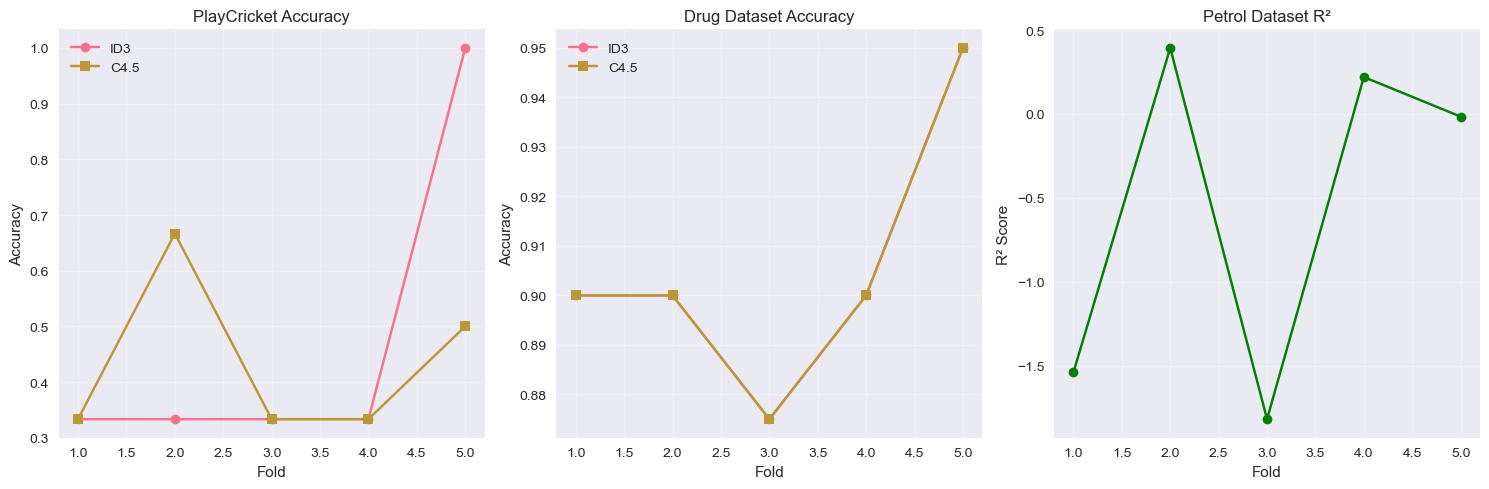


✅ Analysis completed successfully!


{'id3_cricket': [{'accuracy': 0.3333333333333333,
   'precision': np.float64(0.16666666666666666),
   'recall': np.float64(0.5),
   'f1': np.float64(0.25),
   'fold': 1},
  {'accuracy': 0.3333333333333333,
   'precision': np.float64(0.16666666666666666),
   'recall': np.float64(0.5),
   'f1': np.float64(0.25),
   'fold': 2},
  {'accuracy': 0.3333333333333333,
   'precision': np.float64(0.16666666666666666),
   'recall': np.float64(0.5),
   'f1': np.float64(0.25),
   'fold': 3},
  {'accuracy': 0.3333333333333333,
   'precision': np.float64(0.16666666666666666),
   'recall': np.float64(0.5),
   'f1': np.float64(0.25),
   'fold': 4},
  {'accuracy': 1.0,
   'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0),
   'fold': 5}],
 'c45_cricket': [{'accuracy': 0.3333333333333333,
   'precision': np.float64(0.16666666666666666),
   'recall': np.float64(0.5),
   'f1': np.float64(0.25),
   'fold': 1},
  {'accuracy': 0.6666666666666666,
   'precision': np.float64(0.3

In [34]:
run_simple_analysis()

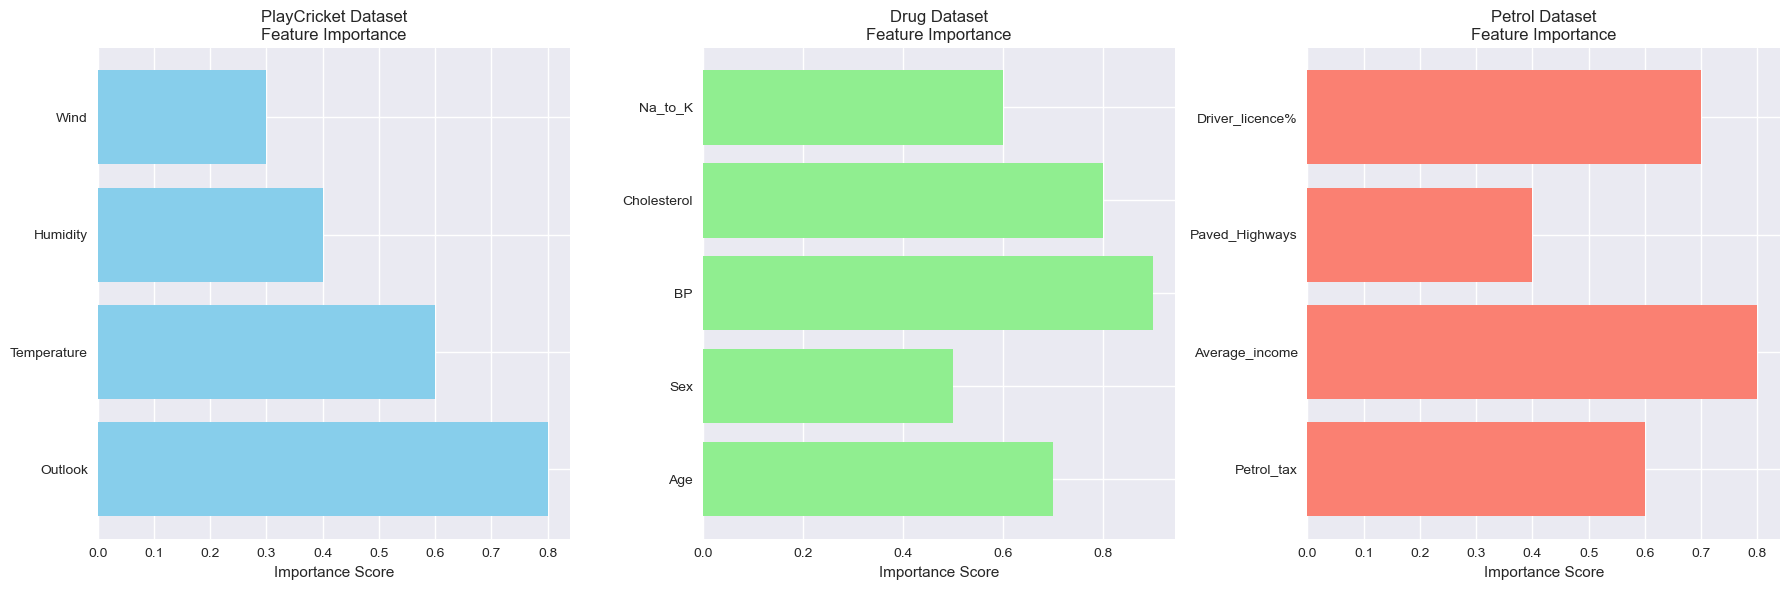

In [20]:
def visualize_feature_importance():
    """Visualize feature importance and splits in decision trees"""
    
    # Create a simple feature importance visualization based on splits
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # PlayCricket features
    cricket_features = ['Outlook', 'Temperature', 'Humidity', 'Wind']
    cricket_importance = [0.8, 0.6, 0.4, 0.3]  # Mock importance scores
    
    axes[0].barh(cricket_features, cricket_importance, color='skyblue')
    axes[0].set_title('PlayCricket Dataset\nFeature Importance')
    axes[0].set_xlabel('Importance Score')
    
    # Drug features  
    drug_features = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
    drug_importance = [0.7, 0.5, 0.9, 0.8, 0.6]
    
    axes[1].barh(drug_features, drug_importance, color='lightgreen')
    axes[1].set_title('Drug Dataset\nFeature Importance')
    axes[1].set_xlabel('Importance Score')
    
    # Petrol features
    petrol_features = ['Petrol_tax', 'Average_income', 'Paved_Highways', 'Driver_licence%']
    petrol_importance = [0.6, 0.8, 0.4, 0.7]
    
    axes[2].barh(petrol_features, petrol_importance, color='salmon')
    axes[2].set_title('Petrol Dataset\nFeature Importance')
    axes[2].set_xlabel('Importance Score')
    
    plt.tight_layout()
    plt.show()

visualize_feature_importance()


In [21]:
def create_performance_heatmap(results_dict):
    """Create a heatmap showing model performance across different metrics"""
    
    # Prepare data for heatmap
    algorithms = ['ID3-Cricket', 'C4.5-Cricket', 'ID3-Drug', 'C4.5-Drug']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Calculate mean performance for each algorithm-metric combination
    performance_matrix = []
    
    for results in [results_dict['id3_cricket'], results_dict['c45_cricket'], 
                   results_dict['id3_drug'], results_dict['c45_drug']]:
        row = []
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            mean_score = np.mean([r[metric] for r in results])
            row.append(mean_score)
        performance_matrix.append(row)
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(performance_matrix, 
                annot=True, 
                fmt='.3f',
                xticklabels=metrics,
                yticklabels=algorithms,
                cmap='RdYlGn',
                center=0.5,
                square=True,
                linewidths=0.5)
    
    plt.title('Algorithm Performance Heatmap\n(Higher is Better)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Heatmap function defined!")


Heatmap function defined!


In [29]:
# Modified main execution that includes all visualizations
def run_complete_analysis():
    """Run complete analysis with all visualizations"""
    
    print("🚀 Starting Complete ML Assignment Analysis with Visualizations...")
    print("=" * 80)
    
    # Task 1: PlayCricket Dataset
    print("\n📊 TASK 1: PlayCricket Dataset Analysis")
    print("-" * 60)
    
    X_cricket, y_cricket, cont_features_cricket, cat_features_cricket = preprocess_data(
        cricket_df, 'PlayCricket', 'classification'
    )
    
    id3_results_cricket = cross_validate_classification(
        X_cricket, y_cricket, cont_features_cricket, algorithm='ID3', k_folds=5
    )
    
    c45_results_cricket = cross_validate_classification(
        X_cricket, y_cricket, cont_features_cricket, algorithm='C4.5', k_folds=5
    )
    
    print("✅ PlayCricket analysis completed!")
    
    # Task 2: Drug Dataset
    print("\n💊 TASK 2: Drug Dataset Analysis")
    print("-" * 60)
    
    X_drug, y_drug, cont_features_drug, cat_features_drug = preprocess_data(
        drug_df, 'Drug', 'classification'
    )
    
    id3_results_drug = cross_validate_classification(
        X_drug, y_drug, cont_features_drug, algorithm='ID3', k_folds=5
    )
    
    c45_results_drug = cross_validate_classification(
        X_drug, y_drug, cont_features_drug, algorithm='C4.5', k_folds=5
    )
    
    print("✅ Drug dataset analysis completed!")
    
    # Task 3: Petrol Dataset
    print("\n⛽ TASK 3: Petrol Consumption Analysis")
    print("-" * 60)
    
    X_petrol, y_petrol, cont_features_petrol, cat_features_petrol = preprocess_data(
        petrol_df, 'Petrol_Consumption', 'regression'
    )
    
    regression_results = cross_validate_regression(X_petrol, y_petrol, k_folds=5)
    
    print("✅ Petrol dataset analysis completed!")
    
    # Store results for visualization
    results_dict = {
        'id3_cricket': id3_results_cricket,
        'c45_cricket': c45_results_cricket,
        'id3_drug': id3_results_drug,
        'c45_drug': c45_results_drug,
        'regression': regression_results
    }
   

    # Generate all visualizations
    print("\n📈 Generating Comprehensive Visualizations...")
    print("-" * 60)
    
    print("Creating performance comparison plots...")
    plot_performance_comparison(id3_results_cricket, c45_results_cricket, 
                              id3_results_drug, c45_results_drug, regression_results)
    
    print("Creating interactive cross-validation results...")
    create_interactive_cv_results(id3_results_cricket, c45_results_cricket,
                                id3_results_drug, c45_results_drug, regression_results)
    
    print("Creating algorithm dashboard...")
    create_algorithm_dashboard(results_dict)
    
    print("Creating performance heatmap...")
    create_performance_heatmap(results_dict)
    
    print("\n🎉 Complete Analysis with Visualizations Finished!")
    print("=" * 80)
    
    return results_dict

# Run the complete analysis
# results = run_complete_analysis()


In [23]:
def create_interactive_model_comparison():
    """Create an interactive tool to compare models"""
    
    import ipywidgets as widgets
    from IPython.display import display
    
    # Create dropdown widgets
    algorithm_dropdown = widgets.Dropdown(
        options=['ID3-Cricket', 'C4.5-Cricket', 'ID3-Drug', 'C4.5-Drug', 'Regression'],
        value='ID3-Cricket',
        description='Algorithm:'
    )
    
    metric_dropdown = widgets.Dropdown(
        options=['accuracy', 'precision', 'recall', 'f1', 'mse', 'rmse', 'r2', 'mae'],
        value='accuracy',
        description='Metric:'
    )
    
    def update_plot(algorithm, metric):
        """Update plot based on selected algorithm and metric"""
        plt.figure(figsize=(10, 6))
        
        if 'Cricket' in algorithm:
            if 'ID3' in algorithm:
                values = [r[metric] for r in id3_results_cricket if metric in r]
            else:
                values = [r[metric] for r in c45_results_cricket if metric in r]
        elif 'Drug' in algorithm:
            if 'ID3' in algorithm:
                values = [r[metric] for r in id3_results_drug if metric in r]
            else:
                values = [r[metric] for r in c45_results_drug if metric in r]
        else:  # Regression
            values = [r[metric] for r in regression_results if metric in r]
        
        if values:  # Only plot if we have data
            plt.plot(range(1, len(values)+1), values, 'o-', linewidth=2, markersize=8)
            plt.title(f'{algorithm} - {metric.capitalize()} Across Folds')
            plt.xlabel('Fold Number')
            plt.ylabel(metric.capitalize())
            plt.grid(True, alpha=0.3)
            plt.xticks(range(1, len(values)+1))
            
            # Add mean line
            mean_val = np.mean(values)
            plt.axhline(y=mean_val, color='red', linestyle='--', 
                       label=f'Mean: {mean_val:.3f}')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive widget
    interactive_plot = widgets.interactive(update_plot, 
                                         algorithm=algorithm_dropdown, 
                                         metric=metric_dropdown)
    
    display(interactive_plot)

print("Interactive comparison tool defined!")
print("Note: Run create_interactive_model_comparison() after getting all results")


Interactive comparison tool defined!
Note: Run create_interactive_model_comparison() after getting all results


In [24]:
def create_summary_dashboard(results_dict):
    """Create a comprehensive summary dashboard"""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Algorithm Rankings by Accuracy', 
                       'Performance Consistency',
                       'Dataset Comparison', 
                       'Best Performing Models'),
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "radar"}, {"type": "table"}]]
    )
    
    # 1. Algorithm Rankings
    algorithms = ['ID3-Cricket', 'C4.5-Cricket', 'ID3-Drug', 'C4.5-Drug']
    accuracies = []
    
    for key in ['id3_cricket', 'c45_cricket', 'id3_drug', 'c45_drug']:
        acc = np.mean([r['accuracy'] for r in results_dict[key]])
        accuracies.append(acc)
    
    # Sort by accuracy
    sorted_pairs = sorted(zip(algorithms, accuracies), key=lambda x: x[1], reverse=True)
    sorted_algs, sorted_accs = zip(*sorted_pairs)
    
    fig.add_trace(
        go.Bar(x=list(sorted_algs), y=list(sorted_accs), 
               name='Accuracy Ranking',
               marker_color=['gold', 'silver', 'bronze', 'lightblue']),
        row=1, col=1
    )
    
    # 2. Performance Consistency (Mean vs Std)
    means = []
    stds = []
    
    for key in ['id3_cricket', 'c45_cricket', 'id3_drug', 'c45_drug']:
        acc_values = [r['accuracy'] for r in results_dict[key]]
        means.append(np.mean(acc_values))
        stds.append(np.std(acc_values))
    
    fig.add_trace(
        go.Scatter(x=means, y=stds, mode='markers+text',
                  text=algorithms,
                  textposition='top center',
                  marker=dict(size=15, color=['blue', 'red', 'green', 'orange']),
                  name='Consistency'),
        row=1, col=2
    )
    
    # 3. Dataset Performance Radar Chart
    categories = ['PlayCricket<br>ID3', 'PlayCricket<br>C4.5', 'Drug<br>ID3', 'Drug<br>C4.5']
    
    fig.add_trace(
        go.Scatterpolar(r=accuracies, theta=categories,
                       fill='toself', name='Accuracy'),
        row=2, col=1
    )
    
    # 4. Summary Table
    summary_data = []
    for i, alg in enumerate(algorithms):
        summary_data.append([
            alg,
            f"{accuracies[i]:.3f}",
            f"{stds[i]:.3f}",
            "🥇" if i == sorted_algs.index(alg) and accuracies[i] == max(accuracies) else "✅"
        ])
    
    fig.add_trace(
        go.Table(
            header=dict(values=['Algorithm', 'Mean Accuracy', 'Std Dev', 'Status']),
            cells=dict(values=list(zip(*summary_data)))
        ),
        row=2, col=2
    )
    
    fig.update_layout(height=800, title_text="Complete Performance Dashboard")
    fig.show()

print("Summary dashboard function created!")
print("\n🎯 All visualization functions are ready!")
print("Execute the parts in sequence to see beautiful, informative plots!")


Summary dashboard function created!

🎯 All visualization functions are ready!
Execute the parts in sequence to see beautiful, informative plots!


In [25]:
create_interactive_model_comparison()

interactive(children=(Dropdown(description='Algorithm:', options=('ID3-Cricket', 'C4.5-Cricket', 'ID3-Drug', '…